# Présentation générale du projet

L'idée initiale de ce projet était d'étudier le lien entre l'orientation politique et des variables "originales". Nous voulions voir s'il y avait un lien, et si oui, dans quelle mesure ce lien était-il fort.

Nous avions donc en premier lieu choisi d'analyser le caractère "fleuri" de certaines villes. Après avoir fait des tentatives de scrapping de ce site et en avoir discuté avec notre chargé de td, nous avons estimé que récupérer les données dont nous avions besoin serait trop coûteux en terme de temps et d'énergie et nous avons abandonné cette première option.

Nous nous sommes donc rabattues sur les tables de l'INSEE, qui étaient téléchargeables ou disponibles avec des liens API. Le catalogue de l'INSEE proposait de nombreuses bases intéressantes mais les thèmes que nous aurions pu aborder (toujours en lien avec la politique). Nous nous étions tout d'abord orientées vers des bases nous permettant d'avoir d'étudier des variables lourdes assez "classiques" (sexe, âge, revenu). Cependant, nous n'avions accès à des résultats électoraux qu'au niveau de la commune (pour le niveau le plus fin qu'il était possible de jointer avec les bases de l'INSEE), et nous avions donc peur que les données aient une variance trop faible pour avoir des résultats intéressants (notamment l'âge ou le sexe). 

C'est ainsi que nous avons décidé d'utiliser la base regroupant toutes les infrastructures présentes en France. Cette base est intéressante car très fournie, et parce qu'elle permet d'étudier caractéristiques des communes, telles que leur proximité à la culture, ou la présence de services publics qu'il peut y avoir.

D'un autre côté, nous devions trouver la base de données qui nous permettrait d'étudier l'orientation politique des communes. Nous avons alors été confrontées à plusieurs difficultés dans le choix de la base et dans l'évaluation de leur orientation politique :
- un choix naturel aurait été d'étudier les élections municipales car notre population étudiée était les communes françaises ; mais les élections municipales présentaient trop de candidats sans étiquette alors impossibles à placer sur l'axe gauche droite, de même, pour les élections législatives, les partis ne présentaient pas des candidats dans toutes les circonscriptions, ce qui posait problème pour notre analyse -> finalement nous avons choisi la base des élections présidentielles de 2017 ;
- l'autre problème a été l'évaluation du bord politique du parti. Plusieurs options s'offraient à nous : placer chaque parti sur un axe gradué gauche-droite et faire une moyenne (quelle moyenne ?) ou s'intéresser à certains partis, mais alors lesquels ? Finalement, nous avons choisi la deuxième option, et nous sommes intéressées aux partis LFI et RN, et donc, dans le contexte de l'élection présidentielle de 2022, aux résultats respectifs de M. Mélenchon et Mme Le Pen. 

En résumé, notre objectif a été d'étudier les liens entre les infrastructures présentes dans la ville (et à travers cela, l'accès aux infrastructures de loisir, de santé ou de services publiques) et le vote pour les partis LFI et RN lors des élections présidentielles de 2022.

> [site internet du label villes et villages fleuris](https://villes-et-villages-fleuris.com/)

> [documentation](https://github.com/heloise1414/Projet-Python-S3/blob/main/code/documentation.ipynb)



# Récupération des données et nettoyage

Dans cette première partie, nous allons récupérer les données et les nettoyer. Cette partie nécessite l'installation du module openpyxl afin de bien fonctionner. Nous allons détailler la récupération dde chaque base ainsi que les sources dans la partie dédiée.

# 0. Préparation de l'environnement de travail

Pour le bon déroulé du projet, on installe les packages suivants : 
- requests : pour la récupération des données par API
- pandas : pour la création et la manipulation de tableaux de données
- zipfile : pour ouvrir, lire ou extraire des données compressées
- os : pour interagir avec le système de fichiers

In [3]:
import requests
import pandas as pd
import zipfile
import os

# 1. Importation des données

Les sources que nous avons utilisées proposaient toutes des liens pour les requêtes API, mais nous avons préféré diversifier les manières de télécharger les bases afin de s'approprier les différentes méthodes. Nous avons donc utilisé une API pour la base de donnée sur les élections car le site proposait une API stable, et nous avons téléchargé la base des infrastructures.

## a. Elections présidentielles

Le choix de la base à étudier pour évaluer l'orientation politique des communes a été compliqué. Nous n'avions pas de souci de récupération des bases car tout était disponible sur le [site data.gouv](https://www.data.gouv.fr/datasets/search), en revanche, nous avions presque trop d'options.

Ainsi, nous avons hésité entre trois bases :
- [élections municipales 2020](https://www.data.gouv.fr/datasets/elections-municipales-2020-resultats-1er-tour) : l'avantage de cette base était le fait d'étudier des élus locaux pour une population locale (les communes), les limites étaient le grand nombre de candidats sans étiquette, particulièrement dans les petites communes, la date des dernières élections (un peu anciennes), et le taux élevé d'abstention ;
- [élections législatives 2024](https://www.data.gouv.fr/datasets/elections-legislatives-des-30-juin-et-7-juillet-2024-resultats-definitifs-du-1er-tour) : l'avantage de cette base était la date de ces élections, qui correspondait à celle de notre base sur les infrastructures, les limites était la volatilité des candidats. Tous les partis ne présentaient pas des candidats dans toutes les circonscriptions, généralement ils présentent un candidat dans les circonscriptions qu'ils estiment pouvoir gagner. Ainsi, nous risquions d'avoir une corrélation complètement surévaluée ;
- [élection présidentielle 2022](https://www.data.gouv.fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour) : finalement, nous avons opté pour l'élection présidentielle de 2022. Les candidats étaient les mêmes pour tous les bureaux de vote ce qui nous simplifiait largement le travail. Les limites de cette base sont toutefois nombreuses, nous y reviendrons au fur et à mesure de notre étude, mais nous avons a priori repéré deux grands problèmes liés à la conjoncture politique et à la nature de l'élection : d'une part, on peut craindre un "effet candidat" (autrement dit, l'élection présidentielle nous permet de mesurer l'adhésion à un candidat et non à un parti), par ailleurs un "effet conjoncture" dû aux élections précédentes (et au second tour avec M. Macron et Mme Le Pen) qui pourrait influencer les comportements des électeurs.

Le choix d'étudier le premier tour de l'élection nous a paru assez naturel car il permettait d'éviter d'avoir un duel et un vote barrage. Malheureusement, le niveau communal n'est pas proposé, donc nous avons choisi de télécharger le niveau **sous-communal** dans l'optique d'agréger les résultats par la suite. 

In [4]:
url_elect = "https://www.data.gouv.fr/api/1/datasets/r/6d9b33e5-667d-4c3e-9a0b-5fdf5baac708"
path_elect = "/home/onyxia/work/Projet-Python-S3/code/results_elect.xlsx"

# Téléchargement du fichier Excel
response = requests.get(url_elect)
response.raise_for_status()

with open(path_elect, "wb") as f:
    f.write(response.content)

# Lecture du fichier Excel
df_extrait = pd.read_excel(path_elect, sheet_name=0)

print("Le dataframe df_extrait peut être traité comme un data frame classique avec pandas")

print("Informations sur le dataframe df_extrait qui est notre df initial")
print(df_extrait.columns)
print(len(df_extrait))


# la colonne unamed 53 correspond au nombre de voix de JLF, la colonne unamed 67 correspond à celui de marine le pen
liste_var = ['Code du département', 
    'Libellé du département', 
    'Code de la commune', 
    'Libellé de la commune',
    'Inscrits', 
    'Abstentions',
    'Exprimés',
    '% Abs/Ins',
    'Unnamed: 51',
    'Unnamed: 53', 
    'Unnamed: 65',
    'Unnamed: 67']
df_elect = df_extrait[liste_var]
df_elect = df_elect.rename(columns={'Unnamed: 51': 'voix_rn'})
df_elect = df_elect.rename(columns={'Unnamed: 53': 'score_rn'})
df_elect = df_elect.rename(columns={'Unnamed: 65': 'voix_lfi'})
df_elect = df_elect.rename(columns={'Unnamed: 67': 'score_lfi'})
print(df_elect.head(3))

Le dataframe df_extrait peut être traité comme un data frame classique avec pandas
Informations sur le dataframe df_extrait qui est notre df initial
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Unnamed: 93', 'Unnamed: 94', 'Unnamed: 95', 'Unnamed: 96',
       'Unnamed: 97', 'Unnamed: 98', 'Unnamed: 99', 'Unnamed: 100',
       'Unnamed: 101', 'Unnamed: 102'],
      dtype='object', length=103)
35245
  Code du département Libellé du département  Code de la commune  \
0                  01                    Ain                   1   
1                  01                    Ain                   2   
2                  01                    Ain                   4   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
0  L'Abergement-Clémenciat       645          108       520      16.74   
1    L'A

Ici, en observant les premières lignes du df, on remarque que certaines villes ont pour code de la commune "1" au lieu de "001". Nous allons donc mettre en forme le df pour que la table soit plus lisible et que la clé externe qui permettra de faire la jointure avec la base des infrastructures fonctionne.

In [5]:
df_elect["Code de la commune"] = df_elect["Code de la commune"].astype(str)
df_elect["Code du département"] = df_elect["Code du département"].astype(str)

On commence par mettre toutes les colonnes au format str.

In [6]:
# la fonction zfill permet de remplir la chaîne de caractères à gauche afin qu'elle ait le bon format (3 caractères)
df_elect["Code de la commune"] = df_elect["Code de la commune"].str.zfill(3)
df_elect["code_insee"] = df_elect["Code du département"] + df_elect["Code de la commune"]
print(df_elect.head(4))

  Code du département Libellé du département Code de la commune  \
0                  01                    Ain                001   
1                  01                    Ain                002   
2                  01                    Ain                004   
3                  01                    Ain                005   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
0  L'Abergement-Clémenciat       645          108       520      16.74   
1    L'Abergement-de-Varey       213           38       171      17.84   
2        Ambérieu-en-Bugey      8765         2078      6553      23.71   
3      Ambérieux-en-Dombes      1282          234      1028      18.25   

   voix_rn  score_rn  voix_lfi  score_lfi code_insee  
0      149     28.65        66      12.69      01001  
1       23     13.45        41      23.98      01002  
2     1646     25.12      1604      24.48      01004  
3      352     34.24       137      13.33      01005  


Ensuite, on s'occupe de créer une colonne code_insee qui a le bon format.

# b. Infrastructures sportives et culturelles

> nous avons choisi le téléchargement car une mise à jour était annoncée pour le 1er janvier 2027 sur le site de l'INSEE (nous ne pouvions donc pas utiliser de requête API).

Cette base de données recense les équipements par type d'équipement et par niveau géographique au 1er janvier de l'année 2024. Les domaines présents dans la table sont les suivants : services pour les particuliers, commerces, enseignement, santé et action sociale, transports et déplacements, sports, loisirs et culture, tourisme. Cela nous permet donc d'étudier des formes d'intégration diverses (intégration administrative, culturelle, économique, etc). 

### i. Données

Dans un premier temps, on récupère les données relatives aux infrastructures sportives et culturelles en France. L'Insee (sur **[insee.fr](https://catalogue-donnees.insee.fr/fr/catalogue/recherche/DS_BPE_SPORT_CULTURE)**) propose une base d'équipements et de service accessibles à la population au niveau communal, intercommunal, départemental, régional... 

> Nous nous intéresserons au **niveau communal**, dans l'optique de faire de même pour les résultats aux élections présidentielles. 

Ce jeu de données est valide pour le **1er janvier 2024**, moins de deux ans après les élections présidentielles. L'écart de temps est donc faible étant donné le temps de construction et la durée de vie en général des infrastructures étudiées, d'où la pertinence de cette base de données. 

<span style="color:red">Le fichier csv téléchargé a été stocké sur notre espace S3 personnel, il faudra probablement changer le chemin d'accès pour y accéder. </span>

In [ ]:
path_infrastructures_s3 = "s3://clemencelucas/projet_python_vote_rn/data/raw/DS_BPE_SPORT_CULTURE_2024_data.csv"
df_infrastructures = pd.read_csv(path_infrastructures_s3, sep=';') 

Pour vérifier que le data frame est bien chargé et pour avoir un premier aperçu des données, on fait quelques vérifications. 

In [ ]:
df_infrastructures.head()

In [ ]:
df_infrastructures.info() 

On remarque en premier lieu qu'il n'y a pas de cases vides car, pour chaque colonne, on a 1 351 761 non-null correspondant à l'entièreté des lignes.  

> **Remarque** : Aucune case n'est vide, mais certaines comportent un code signifiant "Indéterminé" (_U) ou "Sans objet" (_Z). On s'intéressera au problème des valeurs manquantes par la suite.

On observe également que panda interprète la quasi totalité des colonnes comme des types *object* donc on lui indique quels sont les types des colonnes qui nous intéressent. 
- GEO : elle comporte un code, une clé qui permet d'identifier une zone géographique. On pourrait penser qu'il s'agit forcément d'un entier, mais les départements Corses sont 2A et 2B et comportent une lettre, et il arrive que des communes aient un code commençant par 0. Il vaut donc mieux considérer cette colonne comme étant de type *string*
- GEO_OBJECT : elle indique le niveau géographique de la ligne (COM pour commune par exemple). Elle est de type *string*. 
- FACILITY_DOM, FACILITY_SDOM, FACILITY_TYPE : elles indiquent la classification des types d'équipements à différents niveaux (catégories, sous-catégories et types). Ce sont des codes de types *string*. 
- BPE_MEASURE : elle est un indicateur d'intérêt de type *string* (A COMPLETER)
- OBS_VALUE : elle indique le nombre d'équipement décrit dans la ligne par les colonnes précédentes présents dans la zone géographique. Elle est de type *int*, mais panda l'a déjà repéré donc pas besoin de faire de modifications. 

Les autres colonnes concernent un degré de précision quant aux équipements que nous considérons trop élevé pour être pertinent (s'il existe une zone illuminée par exemple avec la variable LIGHTED), donc nous les laissons de côté. 

> **Remarque** TIME_PERIOD indique la période d'observation, lors de l'enquête. En l'occurrence, dans ce jeu de données, cette variable est inutile puisqu'elle contient une unique modalité : 2024. De même, FACILITY_DOM ne prend qu'une valeur : F, qui signifie "Sports, loisirs et cultures".

In [ ]:
#vérification que TIME_PERIOD n'a qu'une valeur 
df_infrastructures["TIME_PERIOD"].value_counts()

In [ ]:
#vérification que FACILITY_DOM n'a qu'une valeur
df_infrastructures["FACILITY_DOM"].value_counts()

In [ ]:
cols_kept = [
    "GEO", "GEO_OBJECT",
    "FACILITY_SDOM", "FACILITY_TYPE",
    "BPE_MEASURE", "OBS_VALUE"
]

df_infrastructures_typed = df_infrastructures[cols_kept].copy() #on fait une copie pour garder quelque part les données originales
df_infrastructures_typed["GEO"] = df_infrastructures_typed["GEO"].astype(str)
df_infrastructures_typed["GEO_OBJECT"] = df_infrastructures_typed["GEO_OBJECT"].astype(str)
df_infrastructures_typed["FACILITY_SDOM"] = df_infrastructures_typed["FACILITY_SDOM"].astype(str)
df_infrastructures_typed["FACILITY_TYPE"] = df_infrastructures_typed["FACILITY_TYPE"].astype(str)
df_infrastructures_typed["BPE_MEASURE"] = df_infrastructures_typed["BPE_MEASURE"].astype(str)

Etant donné la taille considérable du fichier (DS_BPE_SPORT_CULTURE_2024_data.csv), il vaut mieux le transformer au format Parquet pour éviter des temps d'exécution trop élevés. 

In [ ]:
pip install pyarrow

In [ ]:
df_infrastructures_typed.to_parquet(
    "s3://clemencelucas/projet_python_vote_rn/data/intermediate/bpe_parquet_v1",
    engine = "pyarrow",
    index = False, 
    partition_cols = 'GEO_OBJECT'
)

df_infrastructures_typed.head(10)

### ii. Métadonnées

Les métadonnées seront utiles pour avoir des résultats lisibles. Les informations présentes dans le document data comportent essentiellement des codes (F103 pour Tennis par exemple), probablement pour prendre moins d'espace de stockage. Les informations présentes dans le document metadata permettront de clarifier ces clés d'identification. 

In [ ]:
path_infrastructures_meta_s3 = "s3://clemencelucas/projet_python_vote_rn/data/raw/DS_BPE_SPORT_CULTURE_2024_metadata.csv"
df_infrastructures_meta = pd.read_csv(path_infrastructures_meta_s3, sep=';') 

In [ ]:
df_infrastructures_meta.head(20)

In [ ]:
df_infrastructures_meta.info()

Comme pour le document data, d'une part on n'a pas de valeurs nulles et d'autre part panda considère les 4 colonnes du fichier des métadonnées comme étant de type *object*, alors qu'elles sont toutes de type *string*. On les modifie donc, de la même manière en créant une copie du fichier qu'on modifie. 

In [ ]:
df_infrastructures_meta_typed = df_infrastructures_meta.copy() #on fait une copie pour garder quelque part les données originales
df_infrastructures_meta_typed["COD_VAR"] = df_infrastructures_meta_typed["COD_VAR"].astype(str)
df_infrastructures_meta_typed["LIB_VAR"] = df_infrastructures_meta_typed["LIB_VAR"].astype(str)
df_infrastructures_meta_typed["COD_MOD"] = df_infrastructures_meta_typed["COD_MOD"].astype(str)
df_infrastructures_meta_typed["LIB_MOD"] = df_infrastructures_meta_typed["LIB_MOD"].astype(str)

Ce fichier est de taille très faible, donc on le laisse au format CSV.

# 2. Nettoyage des données

## a. Elections présidentielles

### i. Nombre de communes

Pour préparer cette base à nos travaux, nous avons besoin de faire plusieurs vérifications :
- vérifier que nous avons le bon nombre de communes ;
- vérifier que les résultats sont cohérents avec les résultats nationaux de l'élection de 2022 ;

Par ailleurs, les statisticiens ayant déjà utilisé cette base de données ont fait quelques remarques dans l'onglet [discussions](https://www.data.gouv.fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/discussions) du site :

> *[...] je travaille actuellement sur une application qui récupère les résultats des élections et je remarque que pour les élections présidentielles, il semble y manquer les résultats des bureaux de votes du centre de Paris : plus précisément, il manque le 2e, 3e et le 4e arrondissement. Il manque aussi le bureau 72 du 13e, le bureau 58 du 14e, le bureau 6 du 11e et enfin les bureaux 68 et 69 du 17e.[...]*

> *[...] En regardant les résultats par bureau de vote, j'ai trouvé un bureau manquant (numéro 0602 à Lille, code INSEE 59350). Le bureau de vote est bien existant sur le site open data de la métropole de Lille [...]. Et ce bureau ne semble pas faire partie des bureaux annulés par le conseil constitutionnel.*

>*[...] En effet, en comparant le nombre d'inscrits par bureau de vote entre les deux tours, je trouve 25,209 bureaux de vote où le nombre varie (dont 27 où la variation absolue est supérieure à 50 avec un maximum de 8,345 inscrits de différence pour la 3ème circonscription des français de l'étranger). Le site du conseil constitutionnel suggère que cela pourrait être lié à des demandes d'inscriptions dans l'entre-deux-tours liées à des radiations injustifiées des listes électorales [...]. Cependant, alors qu'en 2022 nous avons plus d'inscrits au second tour, en 2017 nous avons moins d'inscrits au premier tour.[...]*

In [7]:
print("Informations sur le dataframe df_elect")
print("Colonnes")
print(df_elect.columns)
print("Nombre de lignes")
print(len(df_elect))
print("Nombre de communes différentes présentes dans la base (d'après code département et code commune)")
print(df_elect[['Code du département', 'Code de la commune']].drop_duplicates().shape[0]) 
    # on doit utiliser les deux variables car le code commune n'est unique qu'au sein du département
print("Vérification des doublons")
print(df_elect[df_elect.duplicated(subset=['Code du département', 'Code de la commune'],keep=False)])

Informations sur le dataframe df_elect
Colonnes
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Inscrits', 'Abstentions', 'Exprimés',
       '% Abs/Ins', 'voix_rn', 'score_rn', 'voix_lfi', 'score_lfi',
       'code_insee'],
      dtype='object')
Nombre de lignes
35245
Nombre de communes différentes présentes dans la base (d'après code département et code commune)
35245
Vérification des doublons
Empty DataFrame
Columns: [Code du département, Libellé du département, Code de la commune, Libellé de la commune, Inscrits, Abstentions, Exprimés, % Abs/Ins, voix_rn, score_rn, voix_lfi, score_lfi, code_insee]
Index: []


Cette sortie python nous permet de savoir plusieurs choses sur la base de données :
- nous avons **35245** communes dans la table, ce qui correspond au nombre de lignes de la table, en revanche, il y avait **[34955 communes](https://fr.wikipedia.org/wiki/Nombre_de_communes_en_France#Ann%C3%A9e_2022)** en France en 2022, nous allons donc devoir approfondir ce point ;
- il n'y a **pas de ville en doublon** dans la table (*Vérification des doublons, Empty DataFrame*)


In [8]:
print("Nombre de communes différentes présentes dans la base (d'après leur nom)")
print(df_elect[['Libellé de la commune']].drop_duplicates().shape[0]) 
    # on doit utiliser les deux variables car le code commune n'est unique qu'au sein du département
print("Vérification des doublons")
print(df_elect[df_elect.duplicated(subset=['Libellé de la commune'],keep=False)])

Nombre de communes différentes présentes dans la base (d'après leur nom)
32988
Vérification des doublons
      Code du département           Libellé du département Code de la commune  \
9                      01                              Ain                011   
23                     01                              Ain                027   
26                     01                              Ain                030   
35                     01                              Ain                039   
38                     01                              Ain                042   
...                   ...                              ...                ...   
35133                  ZZ  Français établis hors de France                109   
35134                  ZZ  Français établis hors de France                110   
35135                  ZZ  Français établis hors de France                111   
35181                  ZZ  Français établis hors de France                160   
3523

Cette sortie nous donne une piste pour les communes "en trop" dans la base : cela peut être dû aux Fraçais établis hors de France, qui ont pourtant le droit de vote et qui votent généralement par correspondance et non dans une commune française. Nous allons creuser cette piste.

1. **Français établis à l'étranger**

In [9]:
df_etranger = df_elect[
    df_elect["Libellé du département"] == "Français établis hors de France"
].copy()
print("Nombre de lignes concernant les Français établis hors de France")
print(len(df_etranger))

Nombre de lignes concernant les Français établis hors de France
210


Nous avons ainsi que **210** des **290** communes présentes "en trop" dans notre base sont en fait des communes étrangères dans lesquelles il y a des bureaux de vote. Nous supprimons donc ces lignes de notre base de données car elle ne rentrent pas dans le champs de notre enquête.

In [10]:
df_elect =  df_elect[
    df_elect["Libellé du département"] != "Français établis hors de France"
].copy()
print("Il y a désormais "+str(len(df_elect))+" communes dans le dataframe")

Il y a désormais 35035 communes dans le dataframe



A ce stade, nous avons plusieurs pistes pour expliquer le nombre trop élevé de communes :
- les arrondissements : il faut regarder les villes de Paris, Lyon et Marseille, pour voir si les arrondissements comptent comme des villes différentes

- les communes déléguées : certaines communes ont été fusionnées mais les ex-communes qui composent la commune nouvelle garde une certaine autonomie lors des élections (notamment avec le mandat de maire délégué), bien qu'il n'y ait normalement pas cela pour l'élection présidentielle, vérifier peut valoir le coup

- les territoires d'outre-mer

> J'avais été confrontée au "problème" des maires délégués lors de mon stage d'application lorsque j'ai travaillé sur le coût d'une [réforme du statut des élus locaux](https://www.senat.fr/leg/ppl24-854.html), c'est donc de là que nous est venu l'idée de regarder cela. (Héloïse)

2. **Arrondissements**

In [11]:
df_Paris = df_elect[
    df_elect["Code du département"] == "75"
].copy()
print("Nombre de lignes concernant Paris")
print(len(df_Paris))

Nombre de lignes concernant Paris
1


Il semble donc que ce n'est pas dû aux arrondissements, car on n'a bien qu'une seule ligne pour Paris.

3. **Communes nouvelles**

Nous allons tester la piste des communes fusionnées. Pour ce faire, nous allons prendre le cas particulier d'une commune, et regardait comment elle apparait dans la base.

J'ai choisi de regarder comment apparaissait une ville à côté de laquelle j'ai grandi. Vire, située dans le Calvados et connue pour sa spécialité locale, l'andouille de Vire, est une commune déléguée :

> *Vire est une ancienne commune française du Bocage virois, située dans le département du Calvados et la région Normandie, devenue le 1er janvier 2016 une commune déléguée au sein de la commune nouvelle de Vire Normandie.* ([Wikipédia](https://fr.wikipedia.org/wiki/Vire))

Elle a ce statut depuis 2016, autrement dit, elle était bien une commune déléguée de Vire Normandie, au même titre que Coulonces, Maisoncelles-la-Jourdan, Roullours, Saint-Germain-de-Tallevende-la-Lande-Vaumont, Truttemer-le-Grand, Truttemer-le-Petit et Vaudry. Nous allons rechercher dans notre base de données pour savoir ce qu'il en est.

In [12]:
df_vire = df_elect[(df_elect["Code du département"] == "14") & (df_elect["Libellé de la commune"] == "Vire-Normandie")].copy()
print("Nombre de fois où apparaît la commune Vire-Normandie")
print (len(df_vire))
df_vire = df_elect[(df_elect["Code du département"] == "14") & (df_elect["Libellé de la commune"] == "Vire")].copy()
print("Nombre de fois où apparaît la commune Vire")
print (len(df_vire))

Nombre de fois où apparaît la commune Vire-Normandie
1
Nombre de fois où apparaît la commune Vire
0


Nous faisons maintenant un deuxième test avec des [communes fusionnées en 2022](https://fr.wikipedia.org/wiki/Liste_des_communes_nouvelles_cr%C3%A9%C3%A9es_en_2022#Liste_d%C3%A9taill%C3%A9e).
> [référence insee](https://www.insee.fr/fr/information/6051727)

In [13]:
code_nouv = ["02054", "16186", "19143", "24325", "25185", "25375", "26216", "56213", "85001"]
df_nouv = df_elect[df_elect["code_insee"].isin(code_nouv)].copy()
print("Nombre de communes nouvelles créées en 2022 apparaissant dans la base")
print (len(df_nouv))


Nombre de communes nouvelles créées en 2022 apparaissant dans la base
9


Nous savons donc que les communes en trop ne sont pas dues aux communes déléguées.

4. **Outre-Mer**

In [27]:
liste_dep = [str(i).zfill(2) for i in range(1, 96)] + ["2A", "2B"]
df_autres = df_elect[~df_elect["Code du département"].isin(liste_dep)].copy()
df_metropole = df_elect[df_elect["Code du département"].isin(liste_dep)].copy()
print("Communes qui ne sont pas dans les départements métropolitains : "+str(len(df_autres)))
print("Communes qui sont dans les départements métropolitains : "+str(len(df_metropole)))
liste_dom = ["Mayotte", "La Réunion", "Guyane", "Guadeloupe", "Martinique"]
df_dom = df_autres[df_autres["Libellé du département"].isin(liste_dom)].copy()
print("Communes des DOM : "+str(len(df_dom)))
df_autres = df_autres[~df_autres["Libellé du département"].isin(liste_dom)].copy()
print("Il y a donc "+str(len(df_autres))+" communes qui sont peut-être nos communes 'en trop'")
nb_communes_autres = df_autres.groupby("Code du département").size()
print(nb_communes_autres)

Communes qui ne sont pas dans les départements métropolitains : 215
Communes qui sont dans les départements métropolitains : 34820
Communes des DOM : 129
Il y a donc 86 communes qui sont peut-être nos communes 'en trop'
Code du département
ZN    33
ZP    48
ZS     2
ZW     1
ZX     2
dtype: int64


Nous savons donc qu'il manque 6 communes métropolitaines. En revanche, nous avons bien réussi à répartir le total des communes supplémentaires et savons que ce sont des communes des territoires d'Outre-Mer qui ne sont pas dans les DOM.

Nous allons donc pour l'instant garder la base telle qu'elle est et nous verrons au moment de faire la jointure si tout fonctionne.

### ii. Electeurs

Dans un premier temps, nous allons vérifier qu'il n'y a pas de communes qui ont un nombre aberrant de votes blancs ou d'abstention.

In [52]:
df_exprime=df_elect[df_elect["Exprimés"] == 0]
print("Dans "+str(len(df_exprime))+" communes, il n'y a eu aucun vote exprimé")
print("Cela concerne un total de "+str(df_exprime['Inscrits'].sum()-df_exprime['Abstentions'].sum())+" inscrits qui auraient alors voté blanc ou nul")
print("Pour "
    + str(len(df_exprime[df_exprime["Exprimés"] < df_exprime["voix_rn"]+df_exprime["voix_lfi"]]))
    + " ligne(s), cela pose problème car on a plus de voix pour les candidats que de voix exprimées.")

Dans 16 communes, il n'y a eu aucun vote exprimé
Cela concerne un total de 4716 inscrits qui auraient alors voté blanc ou nul
Pour 0 ligne(s), cela pose problème car on a plus de voix pour les candidats que de voix exprimées.


In [30]:
df_abstention = df_elect[df_elect["Abstentions"]==df_elect["Inscrits"]]
print("Dans "+str(len(df_abstention))+" commune(s), tous les inscrits se sont abstenus")

Dans 0 commune(s), tous les inscrits se sont abstenus


In [31]:
df_inscrits = df_elect[df_elect["Inscrits"]==0]
print("Dans "+str(len(df_inscrits))+" commune(s), il n'y avait aucun inscrit sur la liste")

Dans 0 commune(s), il n'y avait aucun inscrit sur la liste


On considérera d'après ces résultats que la base ne contient pas de valeur aberrantes, car on n'a que très peu de communes concernées par des valeurs étonnantes (uniquement des votes nuls ou blancs), et cela concerne une quantité infime d'inscrits.

### iii. Résultats du premier tour

Dans un second temps, nous allons vérifier que nous n'avons pas de valeur aberrante dans la base. 

1. **Extrema**

In [30]:
print("Le minimum de vote obtenu par Mme Le Pen est :")
print(df_elect["score_rn"].min())
print(df_elect[df_elect["score_rn"] == df_elect["score_rn"].min()].head(10))

Le minimum de vote obtenu par Mme Le Pen est :
0.0
     Code du département Libellé du département  Code de la commune  \
468                   02                  Aisne                  78   
482                   02                  Aisne                  93   
1744                  05           Hautes-Alpes                  47   
2847                  09                 Ariège                  34   
2971                  09                 Ariège                 162   
3665                  11                   Aude                  93   
3705                  11                   Aude                 134   
3846                  11                   Aude                 277   
6605                  2A           Corse-du-Sud                  65   
6704                  2B            Haute-Corse                   5   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
468                  Besmé       113           20         0      17.70   
482            Blér

In [26]:
print("Score maximal obtenu par le Rassemblement National")
print(df_elect["score_rn"].max())
print(df_elect[df_elect["score_rn"] == df_elect["score_rn"].max()])

Score maximal obtenu par le Rassemblement National
78.0
      Code du département Libellé du département Code de la commune  \
31379                  80                  Somme                418   

      Libellé de la commune  Inscrits  Abstentions  % Abs/Ins  score_rn  \
31379   Hardecourt-aux-Bois        69           17      24.64      78.0   

       score_lfi code_insee  
31379        2.0      80418  


In [27]:
print("Le minimum de vote obtenu par M. Mélenchon est :")
print(df_elect["score_lfi"].min())
print(df_elect[df_elect["score_lfi"] == df_elect["score_lfi"].min()])


Le minimum de vote obtenu par M. Mélenchon est :
0.0
      Code du département Libellé du département Code de la commune  \
435                    02                  Aisne                044   
468                    02                  Aisne                078   
477                    02                  Aisne                087   
482                    02                  Aisne                093   
539                    02                  Aisne                152   
...                   ...                    ...                ...   
33562                  88                 Vosges                288   
33644                  88                 Vosges                374   
33662                  88                 Vosges                394   
34155                  89                  Yonne                413   
34987                  ZP    Polynésie française                716   

      Libellé de la commune  Inscrits  Abstentions  % Abs/Ins  score_rn  \
435                

In [33]:
print("Le maximum de vote obtenu par M. Mélenchon est :")
print(df_elect["score_lfi"].max())
print(df_elect[df_elect["score_lfi"] == df_elect["score_lfi"].max()])

Le maximum de vote obtenu par M. Mélenchon est :
91.03
     Code du département Libellé du département Code de la commune  \
1744                  05           Hautes-Alpes                047   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
1744               Eourres       102           21        78      20.59   

      voix_rn  score_rn  voix_lfi  score_lfi code_insee  
1744        0       0.0        71      91.03      05047  


2. **Résultats**

In [32]:
print("D'après notre base, au premier tour, Mme Le Pen a obtenu "
    + str(round(df_elect['voix_rn'].sum()/df_elect['Exprimés'].sum()*100,2))
    + " % des voix")
print("M. Mélenchon en a obtenu "
    + str(round(df_elect['voix_lfi'].sum()/df_elect['Exprimés'].sum()*100,2))
    + " %")

D'après notre base, au premier tour, Mme Le Pen a obtenu 23.41 % des voix
M. Mélenchon en a obtenu 21.95 %


Nous obtenons bien les résultats auxquels nous nous attendions.

## b. Infrastructures sportives et culturelles

### i. Compréhension des différents niveaux géographiques

Dans un premier temps, il faut appréhender au mieux la base de données pour récupérer uniquement les informations utiles. En particulier, pour le plan géographique, on gardera uniquement ce qui concerne les communes. 

In [ ]:
df_infrastructures_typed["GEO_OBJECT"].value_counts()

In [ ]:
df_infrastructures_meta_typed["COD_VAR"].value_counts()

Les métadonnées ne renseignent rien sur la variable GEO_OBJECT, donc il faut chercher les informations ailleurs. Dans la [table d'appartenance géographique des communes au 1er janvier 2024](https://www.insee.fr/fr/information/7671844), on retrouve les notations DEP, REG, EPCI, ARR, ZE2020, UU2020, AAV2020, BV2022 et leur libellé : 
- AAV2020 : Aire d'Attraction des Villes en 2020
- ARR : Arrondissement 
- BV2022 : Bassin de Vie en 2022
- DEP : Département 
- EPCI : Intercommunalité - Métropole
- REG : Région
- UU2020 : Unité Urbaine en 2020
- ZE2020 : Zone d'emploi en 2020

L'Insee définit également les [EPCI](https://www.insee.fr/fr/information/2510634) comme des Etablissement Public de Coopération Intercommunal. 
Dans la description du [Code Officiel Géographique (COG)](https://www.insee.fr/fr/information/7766585), COM est libellé Code Commune et on retrouve le même résultat pour DEP, REG, ARR que précédemment. 

> Dans la [documentation](https://www.insee.fr/fr/metadonnees/source/operation/s2216/presentation) du dossier, l'Insee précise toutefois que *"dans les communes à arrondissements (Paris-Lyon-Marseille), l'arrondissement a été retenu comme niveau communal pour localiser les équipements."* 

Dans son [résumé du dossier](https://www.insee.fr/fr/metadonnees/source/serie/s1161), l'Insee précise que la base de données couvre le territoire métropolitain et les 5 départements d'outre-mer (Réunion, Guyane, Martinique, Guadeloupe, Mayotte). Néanmoins, il est également écrit que *"Depuis septembre 2018, des données concernant la BPE sont diffusées en évolution sur l'ensemble du territoire, ***hors Mayotte***.*
Etant donné la confusion possible concernant Mayotte, on choisira probablement de négliger ce territoire pour ce projet. Pour le reste, on peut donc considérer que FRANCE désigne la France entière, y compris les territoires d'outre-mer, en gardant en tête qu'il risque d'y avoir une petite variabilité à cause de la non-considération de Mayotte. 

Il reste à traiter le problème des ARM (a priori Arrondissements Municipaux). 

Pour la suite, afin d'avoir des temps d'exécution plus court, on crée des data frame pour chaque niveau géographique pertinent : 
- COM : la commune, puisque c'est notre unité statistique pour ce projet
- FRANCE : peut être pertinent pour comparer par rapport à des moyennes nationales par exemple
- DEP : le département peut-être plus lisible si l'on fait des cartes et peut être intéressant à regarder 
- ARM : l'idée étant de vérifier la nature de cette catégorie, et s'il s'agit bien des Arrondissements Municipaux, il faudra probablement agréger les résultats pour les mettre dans le data frame des communes. 

In [ ]:
df_infrastructures_com = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'COM'].copy()
df_infrastructures_com.head(5)

In [ ]:
df_infrastructures_arm = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'ARM'].copy()
df_infrastructures_arm.head(5)

In [ ]:
df_infrastructures_dep = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'DEP'].copy()
df_infrastructures_dep.head(5)

In [ ]:
df_infrastructures_france = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'FRANCE'].copy()
df_infrastructures_france.head(5)

Comme on a supprimé les colonnes relatives à certaines précisions (présence d'équipement adaptés aux personnes handicapés, vestiaires, etc par exemple), on peut déjà agréger certains résultats. 

In [ ]:
df_infrastructures_com_agg = (
    df_infrastructures_com
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE", "BPE_MEASURE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_com_agg.head(5)

In [ ]:
df_infrastructures_arm_agg = (
    df_infrastructures_arm
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE", "BPE_MEASURE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_arm_agg.head(5)

In [ ]:
df_infrastructures_dep_agg = (
    df_infrastructures_dep
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE", "BPE_MEASURE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_dep_agg.head(5)

In [ ]:
df_infrastructures_france_agg = (
    df_infrastructures_france
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE", "BPE_MEASURE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_france_agg.head(5)

### ii. Traitement des ARM

Pour déterminer à quoi correspond la modalité ARM, on regarde les valeurs prises par la variable GEO. 

In [ ]:
df_infrastructures_arm_agg["GEO"].unique()

In [ ]:
len(df_infrastructures_arm_agg["GEO"].unique())

On a bien les 20+16+9 = 45 arrondissements de Paris, Marseille et Lyon, et on retrouve dans le [COG](https://www.insee.fr/fr/information/7766585) les codes utilisés par l'Insee pour désigner ces-dits arrondissements. 
> Dans le fichier *Liste des communes* avec le filtre TYPECOM = ARM. 

On peut maintenant agréger les résultats des arrondissements municipaux par commune, dans l'objectif de comparer avec ce qui est indiqué pour Paris, Marseille et Lyon dans le dataframe commune (df_infrastructures_com_agg). Pour cela, on crée une nouvelle colonne GEO_COM qui comporte une clé indiquant la commune (Paris, Marseille ou Lille) de l'arrondissement. On prend le premier chiffre de GEO (1 pour Marseille, 6 pour Lyon et 7 pour Paris) car cela suffit pour l'identification. 

In [ ]:
df_infrastructures_arm_agg["GEO_COM"] = df_infrastructures_arm_agg["GEO"].str[0]
df_infrastructures_arm_agg.head(5)

Maintenant on peut agréger avec FACILITY_SDOM, FACILITY_TYPE, BPE_MEASURE et GEO_COM, qu'on replace en premier pour plus de lisibilité. 

In [ ]:
df_infrastructures_arm_agg = (
    df_infrastructures_arm_agg
    .groupby(
        [
            "GEO_COM",
            "FACILITY_SDOM",
            "FACILITY_TYPE",
            "BPE_MEASURE",
        ],
        as_index=False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_arm_agg.head(5)

On remplace GEO_COM par le vrai code COG des communes : 
- Marseille : 13055
- Lyon : 69123
- Paris : 75056

In [ ]:
vrai_cog = {
    "1" : "13055", #Marseille
    "6" : "69123", #Lyon
    "7" : "75056" #Paris
}

df_infrastructures_arm_agg["GEO_COM"] = (
    df_infrastructures_arm_agg["GEO_COM"]
    .map(vrai_cog)
)

df_infrastructures_arm_MLP = df_infrastructures_arm_agg.rename(columns = {"GEO_COM" : "GEO"}).copy()

df_infrastructures_arm_MLP.head(5)

Maintenant on veut comparer ce dernier dataframe avec le contenu de celui des communes (df_infrastructures_com_agg) pour les villes de Marseille, Lyon et Paris uniquement. 

In [ ]:
MLP_cog = ["13055", "69123", "75056"]

df_infrastructures_com_MLP = (
    df_infrastructures_com_agg
    .query("GEO in @MLP_cog")
    .copy()
)

df_infrastructures_com_MLP.head(5)

On remarque déjà grâce aux aperçus des tableaux qu'ils ne commencent pas au même index, donc on commence par réindexer les tableaux avant de les comparer.

In [ ]:
cols = ["GEO","FACILITY_SDOM","FACILITY_TYPE","BPE_MEASURE","OBS_VALUE"]

arm = df_infrastructures_arm_MLP[cols].sort_values(cols).reset_index(drop=True)
com = df_infrastructures_com_MLP[cols].sort_values(cols).reset_index(drop=True)

arm.equals(com)

On confirme ainsi que les données présentes dans le dataframe des communes correspondent aux données agrégées du dataframe des arrondissements municipaux. On peut donc se délester de ce niveau géographique et se concentrer sur celui des communes (sans avoir à modifier df_infrastructures_com_agg). 

### iii. Données manquantes

On regarde l'ensemble des modalités des variables des dataframes étudiés.

In [ ]:
df_infrastructures_com_agg["GEO"].value_counts(dropna=False)

In [ ]:
modalites_geo = (
    df_infrastructures_com_agg["GEO"]
    .unique()
    .tolist()
)

libelles_geo = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "GEO") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_geo)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .drop_duplicates(subset=["COD_MOD"])
    .sort_values("COD_MOD")
)

libelles_geo

> **Remarque** : On a rajouté le drop_duplicate car on avait vu dans l'aperçu qu'au moins une commune était présente deux fois (mêmes COD_MOD et LIB_MOD). 

On observe une différence de 1180 communes entre les deux résultats. On cherche donc à savoir combien de communes présentes dans les données n'ont pas de libellés associés dans les métadonnées. Pour les autres, il est probable qu'il s'agisse de petites communes (villages de moins de quelques centaines d'habitants par exemple) qui n'ont tout simplement pas d'équipement des types étudiés. Ainsi, il n'est pas nécessaire de regarder les communes qui pourraient être présentes dans les métadonnées et pas dans les données. 

In [ ]:
com_data = (
    df_infrastructures_com_agg["GEO"]
    .str.strip()
    .unique()
)

com_meta = (
    df_infrastructures_meta_typed
    .loc[df_infrastructures_meta_typed["COD_VAR"] == "GEO", "COD_MOD"]
    .str.strip()
    .unique()
)

com_data_set = set(com_data)
com_meta_set = set(com_meta)

com_manquantes = sorted(com_data_set - com_meta_set)
len(com_manquantes), com_manquantes

On remarque que tous ces codes ne sont composés que de 4 chiffres au lieu des 5 habituels. Il parait raisonnable de penser qu'il manque un zéro au début de la chaîne de caractère. 

In [ ]:
df_infrastructures_com_agg["GEO_NORM"] = (
    df_infrastructures_com_agg["GEO"]
    .str.zfill(5)
)

df_infrastructures_meta_typed["COD_MOD_NORM"] = (
    df_infrastructures_meta_typed["COD_MOD"]
    .str.zfill(5)
)

On a rajouté des 0 pour être sûr que les codes fassent 5 caractères. On peut revérifier à nouveau chercher les valeurs manquantes et voir combien il en reste. 

In [ ]:
com_data_norm = (
    df_infrastructures_com_agg["GEO_NORM"]
    .str.strip()
    .unique()
)

com_meta_norm = (
    df_infrastructures_meta_typed
    .loc[df_infrastructures_meta_typed["COD_VAR"] == "GEO", "COD_MOD_NORM"]
    .str.strip()
    .unique()
)

com_data_norm_set = set(com_data_norm)
com_meta_norm_set = set(com_meta_norm)

com_manquantes_norm = sorted(com_data_norm_set - com_meta_norm_set)
len(com_manquantes_norm), com_manquantes_norm

Le problème est résolu, on a bien toutes les communes. On considère donc pour la suite que les communes qui ne sont pas mentionnées dans les données n'ont pas d'équipements des types étudiés. 

In [ ]:
df_infrastructures_com_agg["FACILITY_SDOM"].value_counts(dropna=False)

In [ ]:
modalites_facility_sdom = (
    df_infrastructures_com_agg["FACILITY_SDOM"]
    .unique()
    .tolist()
)

libelles_facility_sdom = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "FACILITY_SDOM") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_facility_sdom)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .sort_values("COD_MOD")
)

libelles_facility_sdom

Les équipements des communes sont réparties en trois sous-catégories : 
- F1 : équipements sportifs
- F2 : équipements de loisirs
- F3 : équipements culturels et socio-culturels

Il n'y a pas de données manquantes dans cette colonne. 

In [ ]:
df_infrastructures_com_agg["FACILITY_TYPE"].value_counts(dropna=False)

--------------------------------------------------------------------------------------

1. Préparation des données

Dans un premier temps, nous devons passer d'un format long à un format large. Pour l'instant, cette base contient les colonnes *FACILITY_DOM*, *FACILITY_SDOM* et *FACILITY_TYPE*, qui donnent des informations sur le type d'infrastructures, et surtout, la base contient une ligne par infrastructure. Nous, nous souhaitons une base contenant une ligne par commune et une colonne par infrastructure, colonne qui prendrait comme valeur le nombre de fois où on trouve l'infrastructure dans la ville. 

In [57]:
print("Informations sur le dataframe df_infrastruct")
print(df_infrastruct.columns)
print(df_infrastruct.size)
print(df_infrastruct.head())

Informations sur le dataframe df_infrastruct
Index(['GEO', 'GEO_OBJECT', 'FACILITY_DOM', 'FACILITY_SDOM', 'FACILITY_TYPE',
       'BPE_MEASURE', 'TIME_PERIOD', 'OBS_VALUE'],
      dtype='object')
18403840
     GEO GEO_OBJECT FACILITY_DOM FACILITY_SDOM FACILITY_TYPE BPE_MEASURE  \
0  29305     UU2020            D            D1          D115  FACILITIES   
1  77205     UU2020            D            D2          D265  FACILITIES   
2  31113     UU2020            D            D2          D249  FACILITIES   
3  41501     UU2020            D            D1          D112  FACILITIES   
4  46104     UU2020            D            D2          D266  FACILITIES   

   TIME_PERIOD  OBS_VALUE  
0         2024          1  
1         2024          4  
2         2024          1  
3         2024          1  
4         2024          1  


In [58]:
df_infra_large = (
    df_infrastruct
    .query("TIME_PERIOD == 2024")
    .groupby(["GEO", "FACILITY_TYPE"], as_index=False)["OBS_VALUE"]
    .sum()
    .pivot(index="GEO", columns="FACILITY_TYPE", values="OBS_VALUE")
    .fillna(0)
    .reset_index()
)


In [59]:
print("Vérifications sur le dataframe df_infra_large")
print(df_infra_large.columns)
print(df_infra_large.size)
print(df_infra_large.head())

Vérifications sur le dataframe df_infra_large
Index(['GEO', 'A101', 'A104', 'A105', 'A108', 'A109', 'A120', 'A121', 'A122',
       'A124',
       ...
       'F312', 'F313', 'F314', 'F315', 'G101', 'G102', 'G103', 'G104', 'G105',
       '_T'],
      dtype='object', name='FACILITY_TYPE', length=231)
15345330
FACILITY_TYPE GEO  A101  A104  A105  A108  A109  A120  A121  A122  A124  ...  \
0               1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1               2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2               3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3               4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4               6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

FACILITY_TYPE  F312  F313  F314  F315  G101  G102  G103  G104  G105       _T  
0               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  56142.0  
1               0.0   0.0   0.0   0.0   0.0   0.0   0

2. Nettoyage des données

# Analyse descriptive

Cette partie a pour but de vérifier que les bases sont propres et utilisables correctement. Les statistiques descriptives les statistiques descriptives permettront d'être sûres qu'il n'y a pas de données en double, de données manquantes ou de données aberrantes. 

Une partie analyse descriptive de vos données, avec des figures et les commentaires qui vont avec. Est-ce que cette analyse descriptive nous apprend des choses? Si oui, lesquelles? Est-ce que c’est confirmé par la littérature? Au contraire, si ça ne l’est pas, est-ce qu’on a des éléments d’explication? 

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt

# a. Elections présidentielles

### i. Préparation des données

Nous allons afficher des cartes. Pour ce faire, nous créons un nouveau dataframe *df_departement* qui nous permettra de faire des cartes plus lisibles que le niveau communal.

In [63]:
df_departement = (
    df_elect
    .groupby("Code du département", as_index=False)
    .agg({
        "Inscrits": "sum",
        "Abstentions": "sum",
        "Exprimés": "sum",
        "voix_rn": "sum",
        "voix_lfi": "sum"
    })
)
df_departement['score_dep_rn']=df_departement['voix_rn']/df_departement['Exprimés']
df_departement['score_dep_rn']=df_departement['voix_rn']/df_departement['Exprimés']
print(df_departement.tail(16))

    Code du département  Inscrits  Abstentions  Exprimés  voix_rn  voix_lfi  \
91                   91    799500       192200    594941   105862    167310   
92                   92    997667       208790    774742    64812    199640   
93                   93    793929       239927    543151    64543    266632   
94                   94    796086       195409    589058    69599    192427   
95                   95    733529       192853    529585    91081    175666   
96                   ZA    316023       174592    135085    24204     75862   
97                   ZB    304594       174588    122949    16495     65292   
98                   ZC    102993        65754     35861     6334     18143   
99                   ZD    675539       313159    346766    85770    139604   
100                  ZM     92187        55024     35050    14958      8398   
101                  ZN    218773       145807     70500    13273      9711   
102                  ZP    205576       142121     6

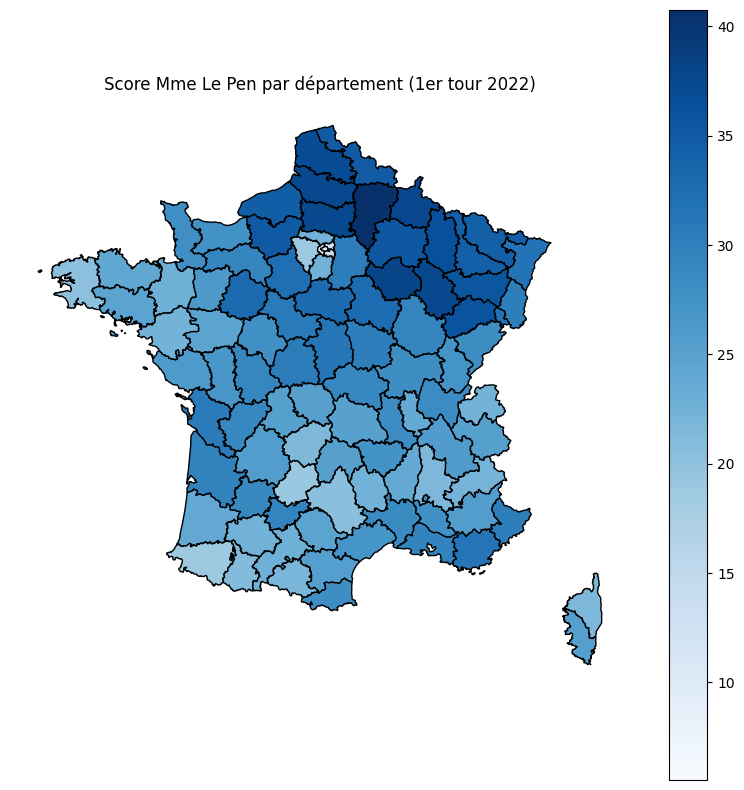

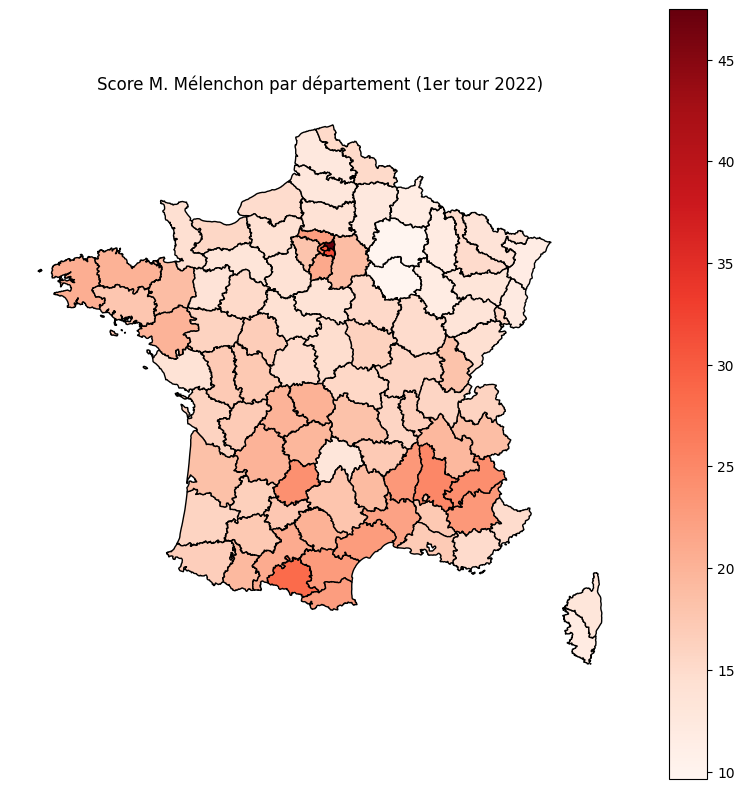

In [62]:
# Préparation du code département : il faut le formater pour qu'il corresponde aux données des fonds de carte

df_elect['Code du département'] = (
    df_elect['Code du département']
    .astype(str)
    .str.zfill(2)
)

# Agrégation par département

# Moyenne des scores communaux

df_dep = (
    df_elect
    .groupby(['Code du département', 'Libellé du département'], as_index=False)
    .agg({
        'score_rn': 'mean',
        'score_lfi': 'mean'
    })
)


# Chargement du fond de carte départements

gdf_dep = gpd.read_file(
    "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
)

gdf_dep['code'] = gdf_dep['code'].astype(str).str.zfill(2)

# Fusion de la carte avec les données

carte_dep = gdf_dep.merge(
    df_dep,
    left_on='code',
    right_on='Code du département',
    how='left'
)

# Carte RN par département

fig, ax = plt.subplots(figsize=(10, 10))

carte_dep.plot(
    column='score_rn',
    cmap='Blues',
    legend=True,
    edgecolor='black',
    ax=ax
)

ax.set_title("Score Mme Le Pen par département (1er tour 2022)")
ax.axis('off')
plt.show()

# Carte LFI par département

fig, ax = plt.subplots(figsize=(10, 10))

carte_dep.plot(
    column='score_lfi',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax
)

ax.set_title("Score M. Mélenchon par département (1er tour 2022)")
ax.axis('off')
plt.show()


Les cartes suivantes sont cohérentes avec les statistiques publiées à propos des élections. Cependant, nous rappelons qu'ici, notre variable d'intérêt est la commune, c'est pour cela que nous n'avons pas pondéré par le nombre d'habitants donc les résultats publiés en ligne. Toutefois, nous ne voyons pas d'incohérence majeure.

# Machine Learning

Une partie machine learning avec le type de modèle utilisé et ce dans le but de confirmer quelle hypothèse? Est-ce que vos données se prêtent bien au modèle que vous utilisez? Est-ce que vous avez fait un prétraitement (centrer réduit par exemple, variables catégories etc…)

# Conclusion

Une partie conclusion où vous rappelez vos résultats principaux mais aussi développez les limites de votre étude : Est-ce que vous pensez avoir complètement répondu à la question? Est-ce que vous avez identifié des angles morts? Comment est-ce que vous feriez pour les corriger etc…